In [ ]:
!pip install pytorch-forecasting
import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.tuner import Tuner

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultiHorizonMetric
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import LabelEncoder

import random
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Build Dataset에서 생성한 train_df를 불러와야 합니다.

train_df_path = #경로지정#
train_df = pd.read_parquet(train_df_path)

In [ ]:
train_df['month'] = train_df['month'].astype(str)
train_df['time_idx'] = train_df['time_idx'].astype(int)
train_df['sales_rate'] = train_df['sales_rate'].astype(float)
train_df['week_weekend'] = train_df['week_weekend'].astype(str)
train_df['special_day'] = train_df['special_day'].astype(str)

max_prediction_length = 21
min_prediction_length = 1
max_encoder_length = 90
training_cutoff = train_df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train_df[lambda x: x['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="sales_rate",
    group_ids=['product_nums'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product", "major", "middle", 'sub', 'brand'],
    static_reals=[],
    time_varying_known_categoricals=['month', 'week_weekend', 'special_day'],
    time_varying_known_reals=[],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["average_month_sales_rate",'sales_rate_log', 'sales_rate','sales',"keyword_cnt"],
    target_normalizer=GroupNormalizer(groups=["product_nums"], method="standard"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, train_df, predict=True, stop_randomization=True)
batch_size = 1589
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12,   batch_sampler='synchronized')
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=12,   batch_sampler='synchronized')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
study_path = #하이퍼파라미터를 불러올 경로를 지정해주세요#
with open(study_path, "rb") as f:
    study = pickle.load(f)

# 2. Get the best hyperparameters from the study
best_hyperparameters = study.best_trial.params
best_hyperparameters

{'gradient_clip_val': 0.03737036693440084,
 'hidden_size': 81,
 'dropout': 0.28740217775266835,
 'hidden_continuous_size': 12,
 'attention_head_size': 2,
 'learning_rate': 0.00585230984542428}

In [ ]:
class PSFA(MultiHorizonMetric):
    def loss(self, y_pred, target):
        y_pred = self.to_prediction(y_pred)
        diff_value = torch.abs(target - y_pred)
        max_value = torch.max(target, y_pred) + 1e-8
        weight = target / (torch.sum(target, axis=0).view(1,y_pred.shape[1]) + 1e-8)
        loss = ((diff_value / max_value) * weight) * (y_pred.shape[0])
        return loss
class SMAPE(MultiHorizonMetric):
    def loss(self, y_pred, target):
        y_pred = self.to_prediction(y_pred)
        loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
        return loss

In [ ]:
dir_path = #모델을 저장할 경로를 지정해주세요#
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=20, monitor = 'val_loss', mode = 'min', dirpath =dir_path, filename = "{epoch:02d}-{val_loss:.7f}" )
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    gradient_clip_val=best_hyperparameters['gradient_clip_val'],
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_hyperparameters['learning_rate'],
    hidden_size=best_hyperparameters['hidden_size'],
    attention_head_size=best_hyperparameters['attention_head_size'],
    dropout=best_hyperparameters['dropout'],
    hidden_continuous_size=best_hyperparameters['hidden_continuous_size'],
    loss=PSFA(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to igno

Number of parameters in network: 1909.5k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/Kkh/data/callback_dir/parameter_tuning/dataset_4/parameter_2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | PSFA                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 305 K 
3  | prescalers                         | ModuleDict            

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


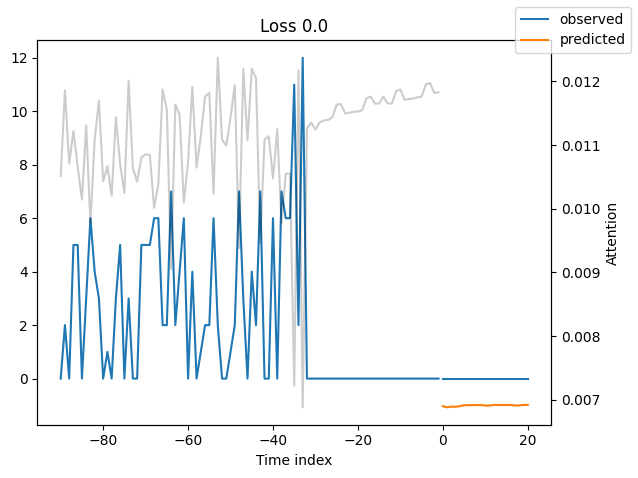

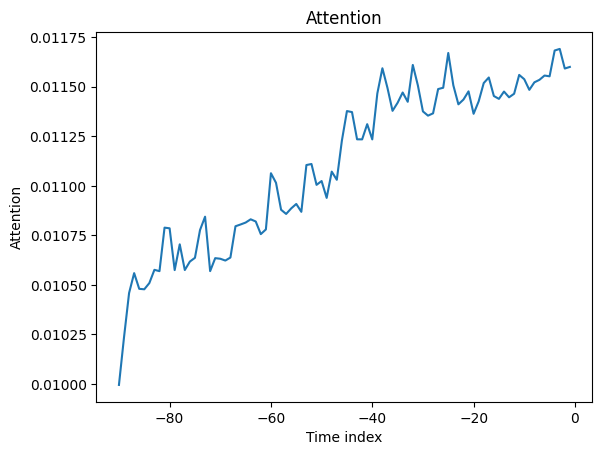

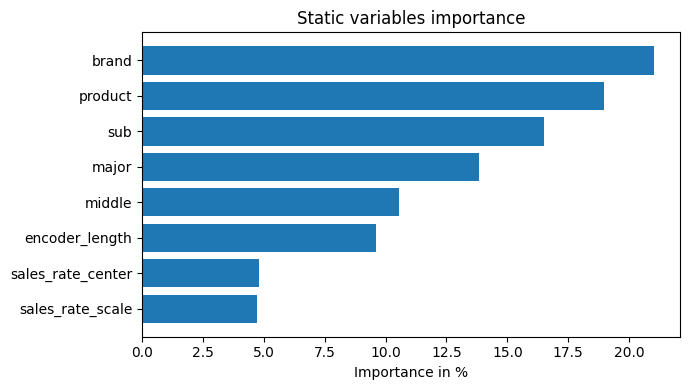

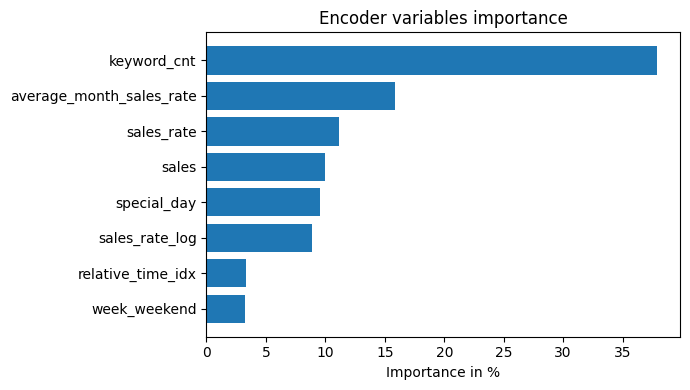

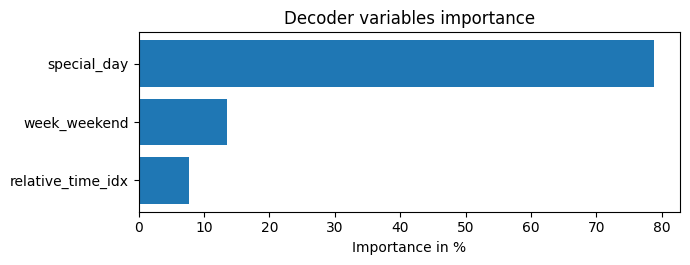

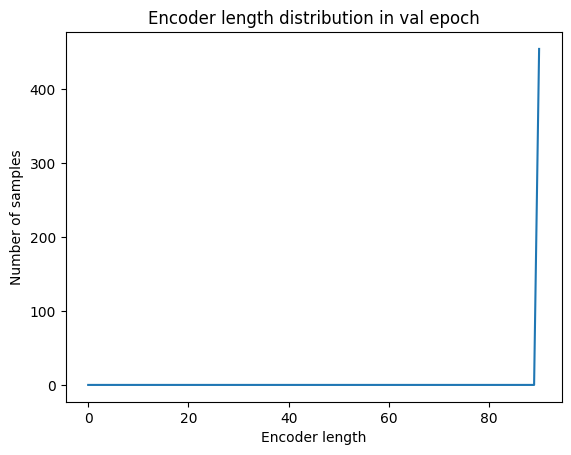

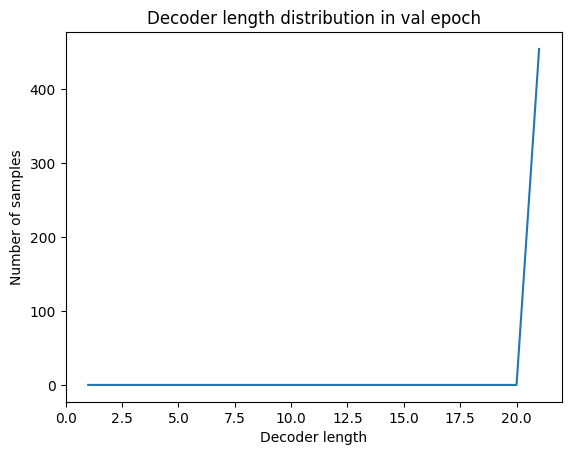

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)